In [1]:
import pandas as pd
import numpy as np
import altair as alt
import altair_saver

## Data ingestion and formating

In [2]:
df = pd.read_csv('../data_mturk/emotion_forced_choice_mturk.csv')
df_labels = pd.read_csv('../data_mturk/emotion_labels.csv')
df_reject = pd.read_csv('../data_mturk/forced_choice_mturk_rejections.csv')

In [3]:
df = df.iloc[5:, :] # filter metadata rows

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 5 to 112
Columns: 221 entries, StartDate to random
dtypes: object(221)
memory usage: 186.6+ KB


In [5]:
df['Finished']

5       TRUE
6       TRUE
7       TRUE
8       TRUE
9       TRUE
       ...  
108    FALSE
109    FALSE
110     TRUE
111     TRUE
112     TRUE
Name: Finished, Length: 108, dtype: object

In [6]:
df = df[~df['random'].isin(df_reject['id_rand'].astype('str'))] # filter out rejected surveys

df = df[df['Finished'] =='TRUE'] # filter out incomplete surveys

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 5 to 112
Columns: 221 entries, StartDate to random
dtypes: object(221)
memory usage: 86.7+ KB


In [8]:
df.rename(columns={
    'Q1.2': 'sex',
    'Q1.3_1': 'age',
    'Q1.4': 'ethnicity',
    'Q1.5': 'formal education',
    'Q1.6_1': 'income'}, inplace=True)

In [9]:
# df.to_csv('../clean_data_mturk/forced_choice_emotion_mturk.csv', index=False)

In [10]:
# placeholders to save svg strings
svg_str = []
image_title = []

In [11]:
def count_freq_labels(df, X="all" ):
    """Returns the frequency and percent of each emotion category in the survey 
    
    Arguments:
    
    df -- dataframe 
    X  -- whether to use all participants, or a subgroup
    """

    if X == "all":
        df_counts = df.stack().reset_index(drop=True).value_counts() # stack as series
        df_counts = df_counts.to_frame('counts') # get value_counts as df
        df_counts['emotion'] = df_counts.index # get index as col
    else:
        df_counts = df[X].reset_index(drop=True).value_counts() # stack as series
        df_counts = df_counts.to_frame('counts') # get value_counts as df
        df_counts[X] = df_counts.index # get index as col

    df_counts = df_counts.reset_index(drop=True) # clean index
    df_counts['percent'] = df_counts['counts'] / df_counts['counts'].sum() # compute percentage
    
    return df_counts

In [12]:
def simple_per_bar(
    df, title='Title', X='percent:Q', Y='emotion:N', \
    width=450, height=250, sort='-x', \
    text_size = 12, label_size = 11, title_size=12, \
    emotion=None, color1='#0570b0', color2='orange'):
    
    """Returns percentage bars by emotion category"""
    
    bars = alt.Chart(df, title=title).mark_bar().encode(
        alt.X(X, axis=alt.Axis(format='.0%')),
        y=alt.Y(Y, sort=sort), 
        color=alt.condition(
            alt.datum.emotion == emotion,
            alt.value(color2),
            alt.value(color1)
        ))
    
    text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
    fontSize=text_size
    ).encode(
        alt.Text(X, format='.1%')
    )
    
    chart = (bars + text).configure_axis(
            labelFontSize=label_size,
            titleFontSize=title_size).properties(
                width=width, 
                height=height)
    
    
    return chart

In [13]:
def simple_per_bar_concat(
    df, title='Title', X='percent:Q', Y='emotion:N',\
    sort='-x', text_size = 12, emotion=None,\
    color1='#0570b0', color2='orange'):
    
    """Returns percentage bars by emotion category for concatenation"""

    bars = alt.Chart(df, title=title).mark_bar().encode(
        alt.X(X, axis=alt.Axis(format='.0%')),
        y=alt.Y(Y, sort=sort), 
        color=alt.condition(
            alt.datum.emotion == emotion,
            alt.value(color2),
            alt.value(color1)
        ))
    
    text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
    fontSize=text_size
    ).encode(
        alt.Text(X, format='.1%')
    )
    
    chart = (bars + text)
    
    return chart

In [14]:
def simple_count_bar(
    df, title='Title', X='counts:Q', Y='emotion:N', \
    width=450, height=250, sort='-x', \
    text_size = 12, label_size = 11, title_size=12,
    emotion=None, color1='#0570b0', color2='#orange'):

    """Return percentage bars by emotion category for concatenation"""

    
    bars = alt.Chart(df, title=title).mark_bar().encode(
        alt.X(X),
        y=alt.Y(Y, sort=sort), 
        color=alt.condition(
            alt.datum.emotion == emotion,
            alt.value(color2),
            alt.value(color1)
        ))
    
    text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
    fontSize=text_size
    ).encode(
        alt.Text(X)
    )
    
    chart = (bars + text).configure_axis(
            labelFontSize=label_size,
            titleFontSize=title_size).properties(
                width=width, 
                height=height)
    
    
    return chart

## Demographics

In [15]:
source = count_freq_labels(df, X="sex") 
title = 'Sex | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'sex:N'
w, h= 450, 150
txs, ls, ts = 12, 12, 12

chart_sex = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)

chart_sex.display(renderer='svg')

alt.LayerChart(...)

In [16]:
chart_sex_string = altair_saver.save(chart_sex, fmt='svg')
image_title.append('Participants by sex')
svg_str.append(chart_sex_string)

In [17]:
source = count_freq_labels(df, X="age") 
n_sample = source['counts'].sum().astype(str)

# binning age for chart
bins = [20, 30, 40, 50, 60]
source['age bins'] = pd.cut(source['age'].astype(int), bins)
source = source.groupby(['age bins'])['percent'].sum().to_frame().reset_index()
source['age bins'] = source['age bins'].astype(str)

title = 'Age | n = '+ n_sample
X, Y = 'percent:Q', 'age bins:N'
w, h= 450, 150
txs, ls, ts = 12, 12, 12

chart_age = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)

chart_age.display(renderer='svg')

alt.LayerChart(...)

In [18]:
chart_age_str = altair_saver.save(chart_age, fmt='svg')
image_title.append('Participants by age')
svg_str.append(chart_age_str)

In [19]:
source = count_freq_labels(df, X="ethnicity") 
title = 'Ethnicity | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'ethnicity:N'
w, h= 450, 150
txs, ls, ts = 12, 11, 12

chart_ethnicity= simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)
chart_ethnicity.display(renderer='svg')

alt.LayerChart(...)

In [20]:
chart_et_str = altair_saver.save(chart_ethnicity, fmt='svg')
image_title.append('Participants by ethnicity')
svg_str.append(chart_et_str)

In [21]:
source = count_freq_labels(df, X="formal education") 
title = 'Formal education | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'formal education:N'
w, h= 450, 150
txs, ls, ts = 12, 11, 12

chart_formal_education= simple_per_bar(
    source, title=title, X=X, Y=Y,\
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)
chart_formal_education.display(renderer='svg')

alt.LayerChart(...)

In [22]:
chart_formal_education_str = altair_saver.save(chart_formal_education, fmt='svg')
image_title.append('Participants by formal education')
svg_str.append(chart_formal_education_str)

df_emo_answers = df.loc[:, 'Q2.1':'Q195.1'] # subset photos
## Overall results

In [23]:
df_emo_answers = df.loc[:, 'Q2.1':'Q195.1'] # subset photos

In [24]:
# df_emo_answers.columns.to_frame().reset_index(drop=True).to_csv('../clean_data/photo_ids.csv', index=False)

In [25]:
source = count_freq_labels(df_emo_answers, X="all") 

# save list of emotions words to avoid repeating this computation later
emotion_words_list = source['emotion'].str.lower().tolist()
# emotion_words_list.remove('other')

title = 'Labels frequency | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12

chart_overall_per = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)

chart_overall_per.display(renderer='svg')

alt.LayerChart(...)

In [26]:
chart_overall_per_str = altair_saver.save(chart_overall_per, fmt='svg')
image_title.append('Overall results by expected label as %')
svg_str.append(chart_overall_per_str)

In [27]:
source = count_freq_labels(df_emo_answers, X="all") 
title = 'Labels frequency | n = '+ source['counts'].sum().astype(str)
X, Y = 'counts:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12

chart_overall_count = simple_count_bar(
    source, title=title, X=X, Y=Y,\
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)

chart_overall_count.display(renderer='svg')

alt.LayerChart(...)

In [28]:
chart_overall_cnt_str = altair_saver.save(chart_overall_count, fmt='svg')
image_title.append('Overall results by expected label as count')
svg_str.append(chart_overall_cnt_str)

## Most frequently used word for each emotion category (grouping pictures by expected-emotion)

In [29]:
def emotion_df_formated(df_emo_answers, emotion_label):
    
    """Returns df with metadata in long format, filtered by emotion
    
    Arguments:
    df_emo_answers -- dataframe with participants answers only
    emotion_label -- emotion label to filter out dataframe
    """
    
    df_emo_cat = df_emo_answers.copy() 
    df_emo_cat_t = df_emo_cat.T # transpose
    df_emo_cat_t['photo_id'] = df_emo_cat_t.index # get index as col
    df_emo_cat_t = df_emo_cat_t.reset_index(drop=True) # clean index
    df_emo_cat_t_labels = pd.concat([df_emo_cat_t, df_labels], axis=1) # add metadata cols
    df_label =  df_emo_cat_t_labels[df_emo_cat_t_labels['label'] == emotion_label]
    
    return df_label

### Anger

In [30]:
emotion = 'anger'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'anger' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_anger = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion.capitalize(), \
    text_size = txs, label_size = ls, title_size=ts)

chart_anger.display(renderer='svg')

alt.LayerChart(...)

In [31]:
chart_anger_str = altair_saver.save(chart_anger, fmt='svg')
image_title.append("Images depicting 'anger'")
svg_str.append(chart_anger_str)

### Disgust

In [32]:
emotion = 'disgust'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'anger' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_disgust = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h,  emotion=emotion.capitalize(),\
    text_size = txs, label_size = ls, title_size=ts)

chart_disgust.display(renderer='svg')

alt.LayerChart(...)

In [33]:
chart_disgust_str = altair_saver.save(chart_disgust, fmt='svg')
image_title.append("Images depicting 'disgust'")
svg_str.append(chart_disgust_str)

### Fear

In [34]:
emotion = 'fear'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'fear' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_fear = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h,  emotion=emotion.capitalize(),\
    text_size = txs, label_size = ls, title_size=ts)

chart_fear.display(renderer='svg')

alt.LayerChart(...)

In [35]:
chart_fear_str = altair_saver.save(chart_fear, fmt='svg')
image_title.append("Images depicting 'fear'")
svg_str.append(chart_fear_str)

### Surprise

In [36]:
emotion = 'surprise'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'surprise' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_surprise = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h,  emotion=emotion.capitalize(), \
    text_size = txs, label_size = ls, title_size=ts)

chart_surprise.display(renderer='svg')

alt.LayerChart(...)

In [37]:
chart_surprise_str = altair_saver.save(chart_surprise, fmt='svg')
image_title.append("Images depicting 'surprise'")
svg_str.append(chart_surprise_str)

### Happiness

In [38]:
emotion = 'happiness'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'happiness' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_happiness = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h,  emotion=emotion.capitalize(),\
    text_size = txs, label_size = ls, title_size=ts)

chart_happiness.display(renderer='svg')

alt.LayerChart(...)

In [39]:
chart_happiness_str = altair_saver.save(chart_happiness, fmt='svg')
image_title.append("Images depicting 'happiness'")
svg_str.append(chart_happiness_str)

### Sadness

In [40]:
emotion = 'sadness'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'sadnes' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_sadness = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h,  emotion=emotion.capitalize(),\
    text_size = txs, label_size = ls, title_size=ts)

chart_sadness.display(renderer='svg')

alt.LayerChart(...)

In [41]:
chart_sadness_str = altair_saver.save(chart_sadness, fmt='svg')
image_title.append("Images depicting 'sadness'")
svg_str.append(chart_sadness_str)

### Uncertain

In [42]:
emotion = 'uncertain'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'uncertain' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_uncertain = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h,  emotion=emotion.capitalize(),\
    text_size = txs, label_size = ls, title_size=ts)

chart_uncertain.display(renderer='svg')

alt.LayerChart(...)

In [43]:
chart_uncertain_str = altair_saver.save(chart_uncertain, fmt='svg')
image_title.append("Images depicting 'uncertain (unknown)'")
svg_str.append(chart_uncertain_str)

### Neutral

In [44]:
emotion = 'neutral'
df_formated = emotion_df_formated(df_emo_answers, emotion) # subset 'neutral' rows
df_formated_ans = df_formated.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)

source = count_freq_labels(df_formated_ans, X="all") 
title = 'Expcted label: '+ emotion + ' | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 200
txs, ls, ts = 12, 11, 12


chart_neutral = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h,  emotion=emotion.capitalize(),\
    text_size = txs, label_size = ls, title_size=ts)

chart_neutral.display(renderer='svg')

alt.LayerChart(...)

In [45]:
chart_neutral_str = altair_saver.save(chart_neutral, fmt='svg')
image_title.append("Images depicting 'neutral'")
svg_str.append(chart_neutral_str)

## Most frequently used word for each emotion category (grouping pictures by expected-emotion), by ethnicity group

In [46]:
def emotion_df_formated_et(df_emo_answers, emotion_label, ethnicity):
    
    """Returns df with metadata in long format, filtered by emotion and ethnicity
    
    Arguments:
    df_emo_answers -- dataframe with participants answers only
    emotion_label -- emotion label to filter out dataframe
    ethnicity -- ethnicity group to filter our dataframe
    """
    
    df_emo_cat = df_emo_answers.copy() 
    df_emo_cat_t = df_emo_cat.T # transpose
    df_emo_cat_t['photo_id'] = df_emo_cat_t.index # get index as col
    df_emo_cat_t = df_emo_cat_t.reset_index(drop=True) # clean index
    df_emo_cat_t_labels = pd.concat([df_emo_cat_t, df_labels], axis=1) # add metadata cols
    df_label =  df_emo_cat_t_labels[(df_emo_cat_t_labels['label'] == emotion_label) & (df_emo_cat_t_labels['ethnicity'] == ethnicity)]
    
    return df_label

In [47]:
def wrapper_chart_emotion(df_emo_answers, emotion, ethnicity):
    
    """Convenience function to generate plots more easily.
    It combines adding metadata, counting, and generetaing charts
    Returns emotion categories percentages for an emotion and ethnicity group"""
    
    df = emotion_df_formated_et(df_emo_answers, emotion,  ethnicity) # subset 'anger' rows
    df_formated_ans = df.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
    df_count = count_freq_labels(df_formated_ans) # count label freq
    chart = simple_per_bar_concat(
        df_count, \
        title='Expected label: '+ emotion + ' | n = '+ df_count['counts'].sum().astype(str), \
         emotion=emotion.capitalize())
    
    return chart

### Anger

In [48]:
chart_anger_bipoc = wrapper_chart_emotion(df_emo_answers, 'anger', 'bipoc')
chart_anger_white = wrapper_chart_emotion(df_emo_answers, 'anger', 'white')

chart_anger_layered =  (chart_anger_bipoc | chart_anger_white)

chart_anger_layered.display(renderer='svg')

alt.HConcatChart(...)

In [49]:
chart_anger_layered_str = altair_saver.save(chart_anger_layered, fmt='svg')
image_title.append("'anger' by ethnicity")
svg_str.append(chart_anger_layered_str)

### Disgust

In [50]:
chart_disgust_bipoc = wrapper_chart_emotion(df_emo_answers, 'disgust', 'bipoc')
chart_disgust_white = wrapper_chart_emotion(df_emo_answers, 'disgust', 'white')

chart_disgust_layered =  (chart_disgust_bipoc | chart_disgust_white)

chart_disgust_layered.display(renderer='svg')

alt.HConcatChart(...)

In [51]:
chart_disgust_layered_str = altair_saver.save(chart_disgust_layered, fmt='svg')
image_title.append("'disgust' by ethnicity")
svg_str.append(chart_disgust_layered_str)

### Fear

In [52]:
chart_fear_bipoc = wrapper_chart_emotion(df_emo_answers, 'fear', 'bipoc')
chart_fear_white = wrapper_chart_emotion(df_emo_answers, 'fear', 'white')

chart_fear_layered =  (chart_fear_bipoc | chart_fear_white)

chart_fear_layered.display(renderer='svg')

alt.HConcatChart(...)

In [53]:
chart_fear_layered_str = altair_saver.save(chart_fear_layered, fmt='svg')
image_title.append("'fear' by ethnicity")
svg_str.append(chart_fear_layered_str)

### Surprise

In [54]:
chart_surprise_bipoc= wrapper_chart_emotion(df_emo_answers, 'surprise', 'bipoc')
chart_surprise_white = wrapper_chart_emotion(df_emo_answers, 'surprise', 'white')

chart_surprise_layered =  (chart_surprise_bipoc | chart_surprise_white)

chart_surprise_layered.display(renderer='svg')

alt.HConcatChart(...)

In [55]:
chart_surprise_layered_str = altair_saver.save(chart_surprise_layered, fmt='svg')
image_title.append("'surprise' by ethnicity")
svg_str.append(chart_surprise_layered_str)

### Happiness

In [56]:
chart_happiness_bipoc = wrapper_chart_emotion(df_emo_answers, 'happiness', 'bipoc')
chart_happiness_white = wrapper_chart_emotion(df_emo_answers, 'happiness', 'white')

chart_happiness_layered =  (chart_happiness_bipoc | chart_happiness_white)

chart_happiness_layered.display(renderer='svg')

alt.HConcatChart(...)

In [57]:
chart_happiness_layered_str = altair_saver.save(chart_happiness_layered, fmt='svg')
image_title.append("'happiness' by ethnicity")
svg_str.append(chart_happiness_layered_str)

### Sadness

In [58]:
chart_sadness_bipoc = wrapper_chart_emotion(df_emo_answers, 'sadness', 'bipoc')
chart_sadness_white = wrapper_chart_emotion(df_emo_answers, 'sadness', 'white')

chart_sadness_layered =  (chart_sadness_bipoc | chart_sadness_white)

chart_sadness_layered.display(renderer='svg')

alt.HConcatChart(...)

In [59]:
chart_sadness_layered_str = altair_saver.save(chart_sadness_layered, fmt='svg')
image_title.append("'sadness' by ethnicity")
svg_str.append(chart_sadness_layered_str)

### Neutral

In [60]:
chart_neutral_bipoc = wrapper_chart_emotion(df_emo_answers, 'neutral', 'bipoc')
chart_neutral_white = wrapper_chart_emotion(df_emo_answers, 'neutral', 'white')

chart_neutral_layered =  (chart_neutral_bipoc | chart_neutral_white)

chart_neutral_layered.display(renderer='svg')

alt.HConcatChart(...)

In [61]:
chart_neutral_layered_str = altair_saver.save(chart_neutral_layered, fmt='svg')
image_title.append("'neutral' by ethnicity")
svg_str.append(chart_neutral_layered_str)

### Uncertain/Other

In [62]:
chart_uncertain_bipoc = wrapper_chart_emotion(df_emo_answers, 'uncertain', 'bipoc')
chart_uncertain_white = wrapper_chart_emotion(df_emo_answers, 'uncertain', 'white')

chart_uncertain_layered =  (chart_uncertain_bipoc | chart_uncertain_white)

chart_uncertain_layered.display(renderer='svg')

alt.HConcatChart(...)

In [63]:
chart_uncertain_layered_str = altair_saver.save(chart_uncertain_layered, fmt='svg')
image_title.append("'uncertain' by ethnicity")
svg_str.append(chart_uncertain_layered_str)

# Emotion percentages as feature vectors

In [64]:
emotion_words_list.remove('other')

In [65]:
# placeholder dataframe
df_emo_features = pd.DataFrame(columns = emotion_words_list) 

# add key-ids
df_emo_features.insert(loc=0, column='photo_id', value=df_emo_answers.columns) 

df_emo_answers = df.loc[:, 'Q2.1':'Q195.1'] # subset photos

In [66]:
def fill_in_emotion_vectors(df_emo_answers, emotion_words_list, fill='counts'):
    
    """Returns dataframe with emotion labels as vector values and metadata"""
    
    # placeholder dataframe
    df_emo_features = pd.DataFrame(columns = emotion_words_list) 
    # add key-ids
    df_emo_features.insert(loc=0, column='photo_id', value=df_emo_answers.columns) 
    
    for emo in range(0, len(emotion_words_list)):
        
        emotion = emotion_words_list[emo] # get emotion word
        df_ans = emotion_df_formated(df_emo_answers, emotion) # ans for all pics of emo-word
        photo_id_list = df_ans['photo_id'].tolist() # photo ids for the emotion word
        splited_photo_id = np.array_split(photo_id_list, 24) # photo_id_list as an array 
        
        for ids in range(0, len(splited_photo_id)):
            photo_id = splited_photo_id[ids]  
            df_single = df_ans[df_ans['photo_id'].isin(photo_id)] # get row for nth photo
            df_emotion_ans = df_single.drop(['photo_id', 'ethnicity', 'sex', \
                                             'age', 'label', 'url', 'photoId'], axis=1) # clean up for calculation
            source = count_freq_labels(df_emotion_ans, X="all") # compute vector-values
            source = source[[fill, 'emotion']].T
            source.columns = source.iloc[1].str.lower() # emotion words as cols
            source.drop('emotion', axis=0, inplace=True) # clean up emotion row
            source.reset_index(drop=True, inplace=True) # clean up index
            source.columns.name = None
            photo_id_str = photo_id[0] # photo id as str
            source.insert(0, 'photo_id', photo_id_str) # photo id as col
            # set photo id as col for easier manipulation
            df_emo_features = df_emo_features.set_index('photo_id') 
            # fill in vectors where the value is available
            df_emo_features.loc[photo_id_str] = pd.Series(source.T.to_dict()[0])
            
            df_emo_features['photo_id'] = df_emo_features.index # index back to column
            df_emo_features.index.name = None 
            df_emo_features.reset_index(drop=True, inplace=True) # clean up index
    
    return df_emo_features 

In [67]:
df_emo_counts = fill_in_emotion_vectors(df_emo_answers, emotion_words_list, fill='counts')
# df_emo_counts = df_emo_counts.fillna(0) # replace NAs with 0
df_emo_counts = pd.concat([df_emo_counts, df_labels], axis=1) # concat metadata
df_emo_counts.to_csv('../clean_data_mturk/forced_choice_mturk_count_emotions.csv', index=False)

In [68]:
df_emo_vectors = fill_in_emotion_vectors(df_emo_answers, emotion_words_list, fill='percent')
df_emo_vectors = df_emo_vectors.fillna(0)
df_emo_vectors = pd.concat([df_emo_vectors, df_labels], axis=1) # concat metadata
df_emo_vectors.to_csv('../clean_data_mturk/forced_choice_mturk_vectors.csv', index=False)

# Clustering

In [69]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing as pp

## K means

### Standarize feature matrix X

In [70]:
X = df_emo_vectors.copy().drop(['photo_id', 'ethnicity', 'sex', \
                                   'age', 'label', 'url', 'photoId'], axis=1)

features = X.columns
sX = pp.MinMaxScaler(copy=True)
X.loc[:,features] = sX.fit_transform(X[features])

X.describe() # mean  = 0, SD =1

,happiness,neutral,sadness,anger,surprise,disgust,fear,uncertain
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.170210,0.184708,0.157961,0.145232,0.129725,0.140607,0.124284,0.181379
std,0.312602,0.260627,0.266075,0.233371,0.221716,0.226563,0.176730,0.176384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.023810,0.005556,0.025000,0.000000,0.000000,0.027778,0.062500
50%,0.020833,0.047619,0.044444,0.050000,0.035714,0.055556,0.055556,0.125000
75%,0.104167,0.255952,0.133333,0.150000,0.095238,0.138889,0.138889,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### K means evaluation to decide on number of clusters

In [71]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

In [72]:
source = pd.DataFrame({'y': sse, 'x': range(1, 11)})

In [73]:
chart_elbow = alt.Chart(source).mark_line().encode(
    alt.X('x:Q', title='Number of clusters'), 
    alt.Y('y:Q', title='SSE'))

In [74]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

5

In [75]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

In [76]:
source = pd.DataFrame({'y': silhouette_coefficients, 'x': range(2, 11)})

In [77]:
chart_silhouette = alt.Chart(source).mark_line().encode(
    alt.X('x:Q', title='Number of clusters'), 
    alt.Y('y:Q', title='Silhouette coefficients'))

In [78]:
kmeans_eval = (chart_silhouette | chart_elbow)

In [79]:
kmeans_eval

alt.HConcatChart(...)

In [80]:
kmeans_eval_str = altair_saver.save(kmeans_eval, fmt='svg')
image_title.append("K-means evaluation")
svg_str.append(kmeans_eval_str)

**K means evaluation**: 

- *Silhoutte coefficients*: increase until 6 clusters; then there is little gain 
- *SSE*: the elbow is at 5, but moving to 6 grants signficant SSE reduction

Combining both criteria, *6 groups seems reasonable*

### K-means clusters

**K-means clustering is run only once here, since results will change with each round. The clusters are plot at the end of this section**

In [81]:
# def k_means(n_clusters=3, n_inits=10, max_iter=500):
    
#     '''kmeans for a single run'''
    
#     kmeans = KMeans(
#     init="random",
#     n_clusters=n_clusters,
#     n_init=n_inits,
#     max_iter=max_iter,
#     random_state=42)
#     kmeans.fit(X)
    
#     return kmeans

In [82]:
# k_means_run = k_means(n_clusters=6)

In [83]:
# df_labels['clusters'] = k_means_run.labels_ ## add clusters id 

# dfs_kmeans = [pd.DataFrame(y) for x, y in df_labels.groupby('clusters', as_index=False)] ## create a Df for each cluster

# # add X, Y coordinates for photos in chart 
# for i in range(0, len(dfs_kmeans)):
#     num_items = len(dfs_kmeans[i])
#     dfs_kmeans[i]['x'] = np.linspace(0.1, 3.0, num=num_items)
#     dfs_kmeans[i]['y'] = np.linspace(0.1, 3.0, num=num_items)

In [84]:
# def grid_photos(nx=6, ny=6, cluster=0,width=600, height=600, title='title'):
    
#     nx, ny = (nx, ny)
#     x = np.linspace(0, 1, nx)
#     y = np.linspace(0, 1, ny)
#     xv, yv = np.meshgrid(x, y)
    
#     dfs_kmeans[cluster]['x'] = xv.ravel()[0:len(dfs_kmeans[cluster])]
#     dfs_kmeans[cluster]['y'] = yv.ravel()[0:len(dfs_kmeans[cluster])]
    
#     chart = alt.Chart(dfs_kmeans[cluster], title=title).mark_image(
#         width=50,
#         height=50
#     ).encode(
#         alt.X('x', axis=None),
#         alt.Y('y', axis=None),
#         url='url'
#     )
    
#     text = chart.mark_text(
#     align='center',
#     baseline='bottom',
#     yOffset = -25
#     #dx=3,  # Nudges text to right so it doesn't appear on top of the bar
#     ).encode(
#         alt.Text('label'),
#         color=alt.Color('label',
#                         scale=alt.Scale(
#                             domain=emotion_words_list,
#                             range=['#ff4444', '#4c809c', '#9ae354', '#ffc286', '#FFA500', '#bd6499', '#c41cac', '#888db5']))
#     )
    
#     return (chart + text).properties(width=width, height=height)

In [85]:
# dims_clusters = []

# for i in range (0, 6):
#     dims_clusters.append(dfs_kmeans[i].shape[0])

    
# dims_clusters

In [86]:
# cluster_0 = grid_photos(nx=7, ny=7, cluster=0, width=400, height=400, title='Cluster 1')
# cluster_1 = grid_photos(nx=5, ny=5, cluster=1, width=400, height=400, title='Cluster 2')
# cluster_2 = grid_photos(nx=7, ny=7, cluster=2, width=400, height=400, title='Cluster 3')
# cluster_3 = grid_photos(nx=6, ny=6, cluster=3, width=400, height=400, title='Cluster 4')
# cluster_4 = grid_photos(nx=5, ny=5, cluster=4, width=400, height=400, title='Cluster 5')
# cluster_5 = grid_photos(nx=7, ny=7, cluster=5, width=400, height=400, title='Cluster 6')

In [87]:
# k_means_clusters = ((cluster_0 | cluster_1) & \
# (cluster_2 | cluster_3) & \
# (cluster_4 | cluster_5)).configure_axis(
#         grid=False
#     ).configure_view(
#         strokeOpacity=0
#     ).configure_concat(
#     spacing=50
# )

In [88]:
# k_means_clusters.display(renderer='svg')

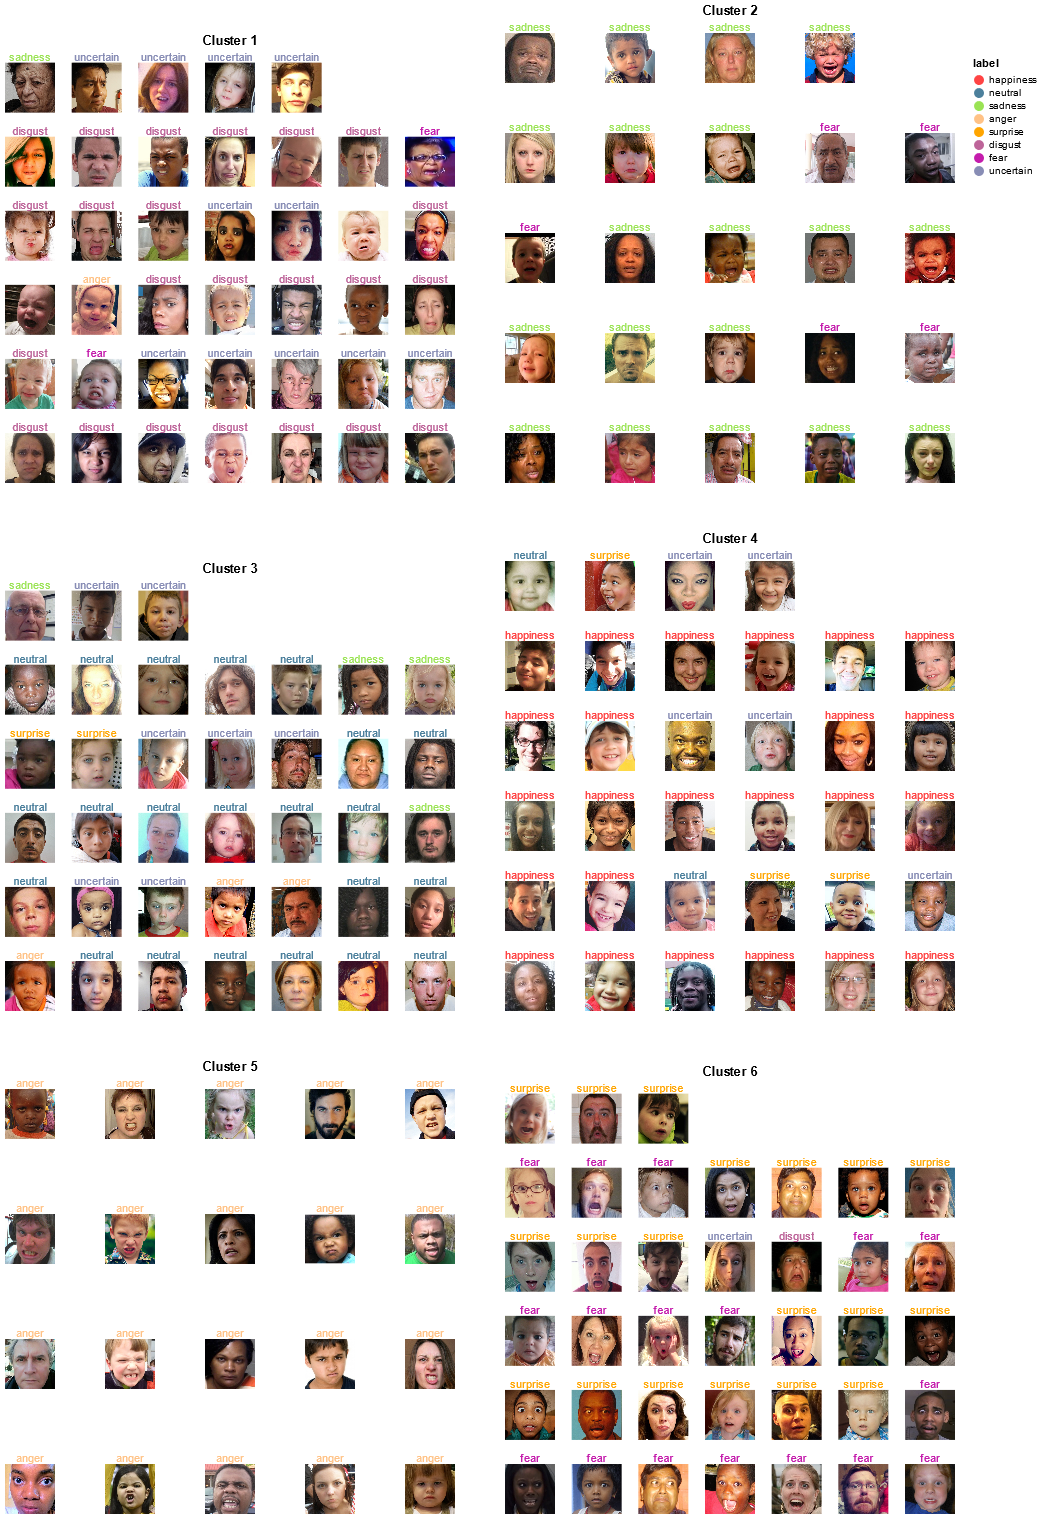

In [94]:
from IPython.display import Image

Image(filename='../data_mturk/k_means_forced_choice_6_mturk.png') 

# Dataframe for dashboard

In [89]:
images_strings = pd.DataFrame({'image_title': image_title, 'svg': svg_str})

In [90]:
images_strings.to_csv('../clean_data_mturk/forced_choice_svg_strings_mturk.csv', index=False)
images_strings.to_csv('../../emotions_dashboard/data/forced_choice_svg_strings_mturk.csv', index=False)

In [91]:
df_svg = pd.read_csv('../clean_data_mturk/forced_choice_svg_strings_mturk.csv')

In [92]:
df_svg['image_title']

0                            Participants by sex
1                            Participants by age
2                      Participants by ethnicity
3               Participants by formal education
4         Overall results by expected label as %
5     Overall results by expected label as count
6                       Images depicting 'anger'
7                     Images depicting 'disgust'
8                        Images depicting 'fear'
9                    Images depicting 'surprise'
10                  Images depicting 'happiness'
11                    Images depicting 'sadness'
12        Images depicting 'uncertain (unknown)'
13                    Images depicting 'neutral'
14                          'anger' by ethnicity
15                        'disgust' by ethnicity
16                           'fear' by ethnicity
17                       'surprise' by ethnicity
18                      'happiness' by ethnicity
19                        'sadness' by ethnicity
20                  